Process: TSFEL feature extraction, log-transform, scaling, pca, and kmeans clustering

Also some plots


created 5/23/2024
updated 6/6/2024

**Imports, Functions, Parameters**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn import preprocessing
import yaml
from glob import glob
import h5py

import tsfel
import random
from datetime import timedelta
import calendar
from tsfel import time_series_features_extractor

from copkmeans.cop_kmeans import cop_kmeans #from https://github.com/Behrouz-Babaki/COP-Kmeans/tree/master, installed 5/25/2023

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples


In [2]:
#get cluster id from template_name
def get_clid(template_str):
    clid_get = (template_str.split('_')[-1])
    return clid_get

#get station name from template name
def getnet_sta(template_str): #for normalized
    t_net = t_name_str.split('_')[0]
    t_sta = t_name_str.split('_')[1]
    return t_net,t_sta

#color map for plotting
def get_cmap(n, name='viridis'): #hsv
#     Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#     RGB color; the keyword argument name must be a standard mpl colormap name.
    return plt.cm.get_cmap(name, n)

#from https://stackoverflow.com/questions/57340166/how-to-plot-the-pricipal-vectors-of-each-variable-after-performing-pca
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, s=10) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center')

#get ncom from idealv using scaling
def ncom_idealv_scaled(ncom_list,idealv,X): #ncom_list is list of options, idealv is ideal variance, x is the data
    sum_list = [] #will be a list of cumulative explained variance ratio for each ncom
    for n_com in ncom_list:
        
        pca = PCA(n_components=n_com) #get the pca function
        scaler = StandardScaler().set_output(transform="pandas")
        scaled_X = scaler.fit_transform(X) #normalize data for scaling
        
        pca.fit(scaled_X) #use pca on data X
        x_new = pca.transform(scaled_X)
#         print(x_new.shape)
        
#         myplot(x_new[:,0:2], pca.components_.T) 
#         plt.show()
#         plt.close()

        vr = pca.explained_variance_ratio_
        sum_list.append(sum(vr))
        
        
        #plot explained varience for each component
#         plt.bar(x=np.arange(0,len(vr),1),height=vr)
# #         plt.yscale('log') #in case drop in vr with each component is large
#         plt.show()
#         plt.close()
        
        print(f'{n_com} components -> {sum(vr)} variance ratio')


    diff_list = [abs(i-idealv) for i in sum_list] #find difference from idealv across ncom_list
    #look through ncom_list to find the ncom closest to idealv
    ncom = ncom_list[diff_list.index(min(diff_list))] #get the minimum difference, find its index, pull from ncom_list
    
    plt.scatter(x=ncom_list,y=sum_list,color='black')
    plt.xlabel('Number of Components')
    plt.ylabel('Sum of Explained Variance')
    plt.show()
    plt.close()
    
    print('auto ncom =',ncom)
    return ncom

#create must-link constraints across stations for cop-kmeans
def must_links(template_name): #input a list of template names containing cluster ID
    ml = [] #list of tuples of must-link pairs by index

    cl_list = np.unique([get_clid(i) for i in template_name])

    idx_grp_list = [] #list of lists of group indexes, not necessary
    for cl in cl_list:
        cl_idx_list = [] #will be a list of indexes in a group (same cluster ID, different station) 
        for tname in template_name:
            if get_clid(tname)==cl:
                cl_idx_list.append(list(template_name).index(tname))
        idx_grp_list.append(cl_idx_list)
        for idx in cl_idx_list: #for each index in this group
            if idx==min(cl_idx_list): #no need to pair min with itself
                continue
            else:
                ml.append((min(cl_idx_list),idx)) #pair each index with the min

    return ml #list of tuples that can be inserted into cop-kmeans clustering

In [3]:
with open('/home/smocz/expand_redpy/scripts/config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

smooth_length = config['smooth_length']
fs = config['fs']
tb = config['tb']
ta = config['ta']
fqmin = config['fqmin']
fqmax = config['fqmax']
chan = config['chan']
homedir = config['homedir']
readdir = config['readdir']
minsta = config['minsta']
grid_length = float(config['grid_length'])
grid_height = float(config['grid_height'])
step = config['step']
t_step = config['t_step']
vs_min = config['vs_min']
vs_max = config['vs_max']
vs_step = config['vs_step']
volc_lat_lon = config['volc_lat_lon']
volc_list_names = config['volc_list_names']

vv = config['vv']
vv=0


print(volc_list_names[vv])

k=6 #number of clusters
tsfel_name = f'{homedir}tsfel_clustering/{volc_list_names[vv]}_tsfel_features.csv'
kmeans_name = f'{homedir}tsfel_clustering/{volc_list_names[vv]}_kmeans{k}.csv'
cop_kmeans_name = f'{homedir}tsfel_clustering/{volc_list_names[vv]}_COPkmeans{k}.csv'

Baker


Pull in template waveforms (needed for TSFEL feature extraction and plots)

In [4]:
#pull in h5 for volcano

all_temps = []
all_waves = []

for filepath in glob(f'/home/smocz/expand_redpy_new_files/h5/normalized_{volc_list_names[vv].lower()}_templates_*.h5'):
    net = filepath.split('_')[-2]
    with h5py.File(filepath, "r") as f: #pull in fingerprints
        template_name = f["template_name"][()]
        waveforms = f["waveforms"][()]
#         print(f.keys()) #print what data is in this file
    [all_temps.append(i) for i in template_name]
    [all_waves.append(i) for i in waveforms]
    
all_waves = np.array(all_waves)
all_temps = [str(i)[2:-1] for i in all_temps]

In [5]:
print(all_temps[0])

CN_VDB_rpba_13


**TSFEL Feature Extraction**

(can be skipped if csv already saved)

In [16]:
eq_Z = all_waves

In [ ]:
# FEATURE EXTRACTIONS #
cfg_file = tsfel.get_features_by_domain()

# Extract features for earthquakes
features_eqz = pd.DataFrame([])
for i in range(0,len(all_temps)+1):
    try:
    
        df = time_series_features_extractor(cfg_file, eq_Z[i], fs=40,)
        df['template'] = all_temps[i]
        features_eqz = pd.concat([features_eqz,df])
        
    except:
        pass

In [20]:
features_eqz.head()

,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,...,0_Negative turning points,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate,template
0,0.000007,2.084414e-07,1.663727e-07,1.354090e-07,2.504511e-07,4.906124e-07,0.000003,0.000005,0.000019,0.000012,...,610.0,174.0,1.145657,609.0,3525.011211,1.787390e-07,140.563815,0.340207,786.0,CN_VDB_rpba_13
0,0.000003,9.535679e-08,8.131142e-08,1.041649e-07,5.680744e-07,7.415959e-07,0.000004,0.000017,0.000018,0.000095,...,584.0,166.0,1.865512,583.0,3540.894734,9.121470e-08,208.314757,0.605287,792.0,CN_VDB_rpba_17
0,0.000010,3.043679e-07,2.668569e-07,2.715262e-07,4.060525e-07,3.050485e-06,0.000011,0.000025,0.000036,0.000093,...,645.0,167.0,1.807313,646.0,3542.741082,1.588311e-08,268.168152,0.694491,904.0,CN_VDB_rpba_18
0,0.000010,3.160428e-07,2.230686e-07,1.518484e-07,1.132205e-07,1.168024e-06,0.000001,0.000006,0.000007,0.000023,...,390.0,155.0,1.929374,390.0,3525.181005,-1.276455e-07,91.312521,0.476757,506.0,CN_VDB_rpba_19
0,0.000004,6.724118e-08,1.018395e-07,3.294907e-07,1.126030e-06,2.666142e-06,0.000011,0.000020,0.000058,0.000052,...,461.0,161.0,1.780600,462.0,3523.499606,-4.476531e-08,77.322400,0.226466,623.0,CN_VDB_rpba_20


In [22]:
#save features to csv

features_eqz.to_csv(tsfel_name)

**Log-transform**

Check if log-normal and then update

In [6]:
#read in the tsfel features csv
features_df = pd.read_csv(tsfel_name)

df = features_df.copy() #create a copy for manipulating
df.dropna(inplace=True)
df.head()
df.drop(['template'], axis=1, inplace=True)
df.isna().sum().any()

False

In [7]:
# Step 1: Calculate skewness for each feature
skewness = df.apply(lambda x: x.skew())

# Step 2: Identify features with high positive skewness (right-skewed)
log_normal_features = skewness[skewness > 1.0].index.tolist()

print(f'{len(log_normal_features)} features are log-normal, out of {len(df.keys())} total features')

283 features are log-normal, out of 390 total features


In [8]:
#transforma all log-normal features

df_log = df.copy()
df_log[log_normal_features] = np.log(df_log[log_normal_features]) # log transform the skewed features

# drop the features with Nan, Inf, Zeros from the data frames.
df_log.dropna(inplace=True,axis=1)
df_log.replace([np.inf, -np.inf], np.nan, inplace=True)
df_log.dropna(inplace=True,axis=1)
df_log.replace(0, np.nan)
df_log.dropna(inplace=True,axis=1)
df_log.isna().sum().any()

/home/smocz/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/smocz/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


False

In [9]:
df_log.describe() #look at stats

,Unnamed: 0,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,...,0_Median diff,0_Negative turning points,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate
count,513.0,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,...,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,5.130000e+02,513.000000,513.000000,513.000000
mean,0.0,-12.530217,-15.522628,-15.055054,-14.425651,-13.696199,-12.830246,-11.843468,-11.123600,-10.432083,...,0.000074,583.617934,155.555556,1.686299,583.649123,8.168769,4.472835e-09,129.198535,-1.075425,730.142300
std,0.0,1.619553,1.807158,2.164866,2.410510,2.479175,2.439753,2.382103,2.274768,2.164706,...,0.000456,89.579804,10.115801,0.195858,89.534875,0.001551,1.507451e-07,54.821136,0.646832,167.365446
min,0.0,-18.590618,-21.935196,-21.685647,-20.973345,-20.259559,-19.802480,-18.609845,-18.191721,-17.123183,...,-0.001717,261.000000,123.000000,0.659375,262.000000,8.166473,-7.413949e-07,9.350481,-3.159132,336.000000
25%,0.0,-13.455647,-16.605224,-16.411562,-16.076296,-15.438204,-14.530559,-13.603296,-12.707299,-11.855540,...,-0.000116,532.000000,149.000000,1.612382,532.000000,8.167659,-3.942191e-08,88.965039,-1.511870,618.000000
50%,0.0,-12.340218,-15.531356,-15.304430,-14.779362,-13.849835,-12.909376,-11.824761,-11.066002,-10.379880,...,0.000028,591.000000,156.000000,1.720701,591.000000,8.168378,-4.355798e-10,122.042882,-1.048984,744.000000
75%,0.0,-11.391911,-14.303731,-13.740956,-12.827531,-11.948377,-11.096454,-10.309163,-9.588684,-8.774508,...,0.000248,645.000000,163.000000,1.822601,645.000000,8.169568,5.247221e-08,160.564592,-0.641777,833.000000
max,0.0,-8.501630,-10.939045,-8.043311,-8.516776,-7.384321,-6.972759,-6.470593,-5.697643,-5.747279,...,0.002267,802.000000,187.000000,1.994205,801.000000,8.177338,1.179803e-06,411.690973,0.622556,1322.000000


**PCA and Scaling**

2 components -> 0.5747013460728613 variance ratio
3 components -> 0.6340696000759569 variance ratio
4 components -> 0.6793370297906404 variance ratio
5 components -> 0.7060166991590493 variance ratio
8 components -> 0.7478751616784042 variance ratio
10 components -> 0.7653393055806461 variance ratio
12 components -> 0.7798170364847897 variance ratio
20 components -> 0.8178710152742048 variance ratio
30 components -> 0.8494365629659771 variance ratio
40 components -> 0.8740726805279956 variance ratio
50 components -> 0.8935016967198609 variance ratio


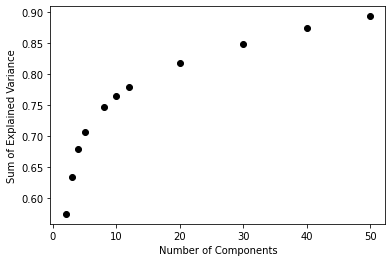

auto ncom = 30


In [10]:
#get ncom (number of components) for PCA, using sum of explained variance.

ncom = ncom_idealv_scaled(ncom_list=[2,3,4,5,8,10,12,20,30,40,50],idealv=0.86,X=df_log.to_numpy())

In [11]:
X = df_log.to_numpy() #X is data/features (log-transformed)

pca = PCA(n_components=ncom) #get the pca function
scaler = StandardScaler().set_output(transform="pandas") #define scaler
scaled_X = scaler.fit_transform(X) #normalize data for scaling

pca.fit(scaled_X) #use pca on data scaled_X
x_new = pca.transform(scaled_X)

**kmeans**

In [12]:
ncluster=k
kmeans_model = KMeans(n_clusters=ncluster, random_state=1).fit(x_new)
labels = kmeans_model.labels_
sc=silhouette_score(x_new, labels, metric='euclidean')
print(f"Silhouette score for {ncluster} clusters: {sc:.3f}")

/home/smocz/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 6 clusters: 0.188


Save Kmeans

In [13]:
save_df = pd.DataFrame(data=[])
save_df['template']=features_df['template'].values.tolist()
save_df['kmeansID']=labels
display(save_df)

,template,kmeansID
0,CN_VDB_rpba_13,3
1,CN_VDB_rpba_17,3
2,CN_VDB_rpba_18,3
3,CN_VDB_rpba_19,2
4,CN_VDB_rpba_20,5
...,...,...
508,UW_SHUK_rpba_248,4
509,UW_SHUK_rpba_249,5
510,UW_SHUK_rpba_251,1
511,UW_SHUK_rpba_252,0


In [14]:
save_df.to_csv(kmeans_name,index=False)

cop-kmeans

In [49]:
from copkmeans.cop_kmeans import cop_kmeans #from https://github.com/Behrouz-Babaki/COP-Kmeans/tree/master
from time import time

ml = must_links(all_temps)

#kmeans
silhouette_avg = 0 #for starting off
t00 = time()
sil_list = [] #list of silhouette scores, used to find average of all attempts at this
i = 0
while silhouette_avg < 0.06 and i < 10:
    t0 = time()
    cop_clusters, cop_centers = cop_kmeans(dataset=x_new, k=k,ml=ml,initialization='kmpp',max_iter=300,tol=1e-4)
    t1 = time()
    # print(f'{t1-t0} seconds for COP-Kmeans')
    silhouette_avg = silhouette_score(x_new, np.array(cop_clusters))
    print(f'sil avg: {silhouette_avg}', end=', ')
    sil_list.append(silhouette_avg)
    i = i +1
t11 = time()
print(f'{t11-t00} seconds to find large enough silhouette score')

sil avg: 0.031912832135480663, sil avg: 0.044396454777102586, sil avg: 0.0303923158214468, sil avg: 0.027811959447688227, sil avg: 0.0303923158214468, sil avg: 0.044396454777102586, sil avg: 0.03874527860351724, sil avg: 0.028712120025397497, sil avg: 0.028785175065974215, sil avg: 0.022645895450026685, 4.421160936355591 seconds to find large enough silhouette score


In [50]:
save_df = pd.DataFrame(data=[])
save_df['template']=all_temps
save_df['kmeansID']=cop_clusters
display(save_df)

,template,kmeansID
0,CN_VDB_rpba_13,3
1,CN_VDB_rpba_17,0
2,CN_VDB_rpba_18,0
3,CN_VDB_rpba_19,1
4,CN_VDB_rpba_20,1
...,...,...
508,UW_SHUK_rpba_248,4
509,UW_SHUK_rpba_249,0
510,UW_SHUK_rpba_251,5
511,UW_SHUK_rpba_252,0


In [51]:
save_df.to_csv(cop_kmeans_name,index=False)

### Kmeans Analysis ###

In [6]:
#read csv

groups_df = pd.read_csv(kmeans_name)
groups_df.head()

,template,kmeansID
0,CN_VDB_rpba_13,3
1,CN_VDB_rpba_17,3
2,CN_VDB_rpba_18,3
3,CN_VDB_rpba_19,2
4,CN_VDB_rpba_20,5


In [7]:
#add waveform to dataframe
groups_df['waveform']= [i for i in all_waves]

In [8]:
groups_df.head()

,template,kmeansID,waveform
0,CN_VDB_rpba_13,3,"[-0.0134396711252262, -0.014672842092771553, -..."
1,CN_VDB_rpba_17,3,"[0.0008055376400464358, -0.0045865051656801235..."
2,CN_VDB_rpba_18,3,"[-0.011902026118720373, 0.025556739409762674, ..."
3,CN_VDB_rpba_19,2,"[-0.01284348664224888, -0.0024739919789767257,..."
4,CN_VDB_rpba_20,5,"[0.004830974781062498, 0.005037140076776008, -..."


number of clusters = 6
149 waveforms, 63 waveforms, 27 waveforms, 128 waveforms, 71 waveforms, 75 waveforms, showing plot...


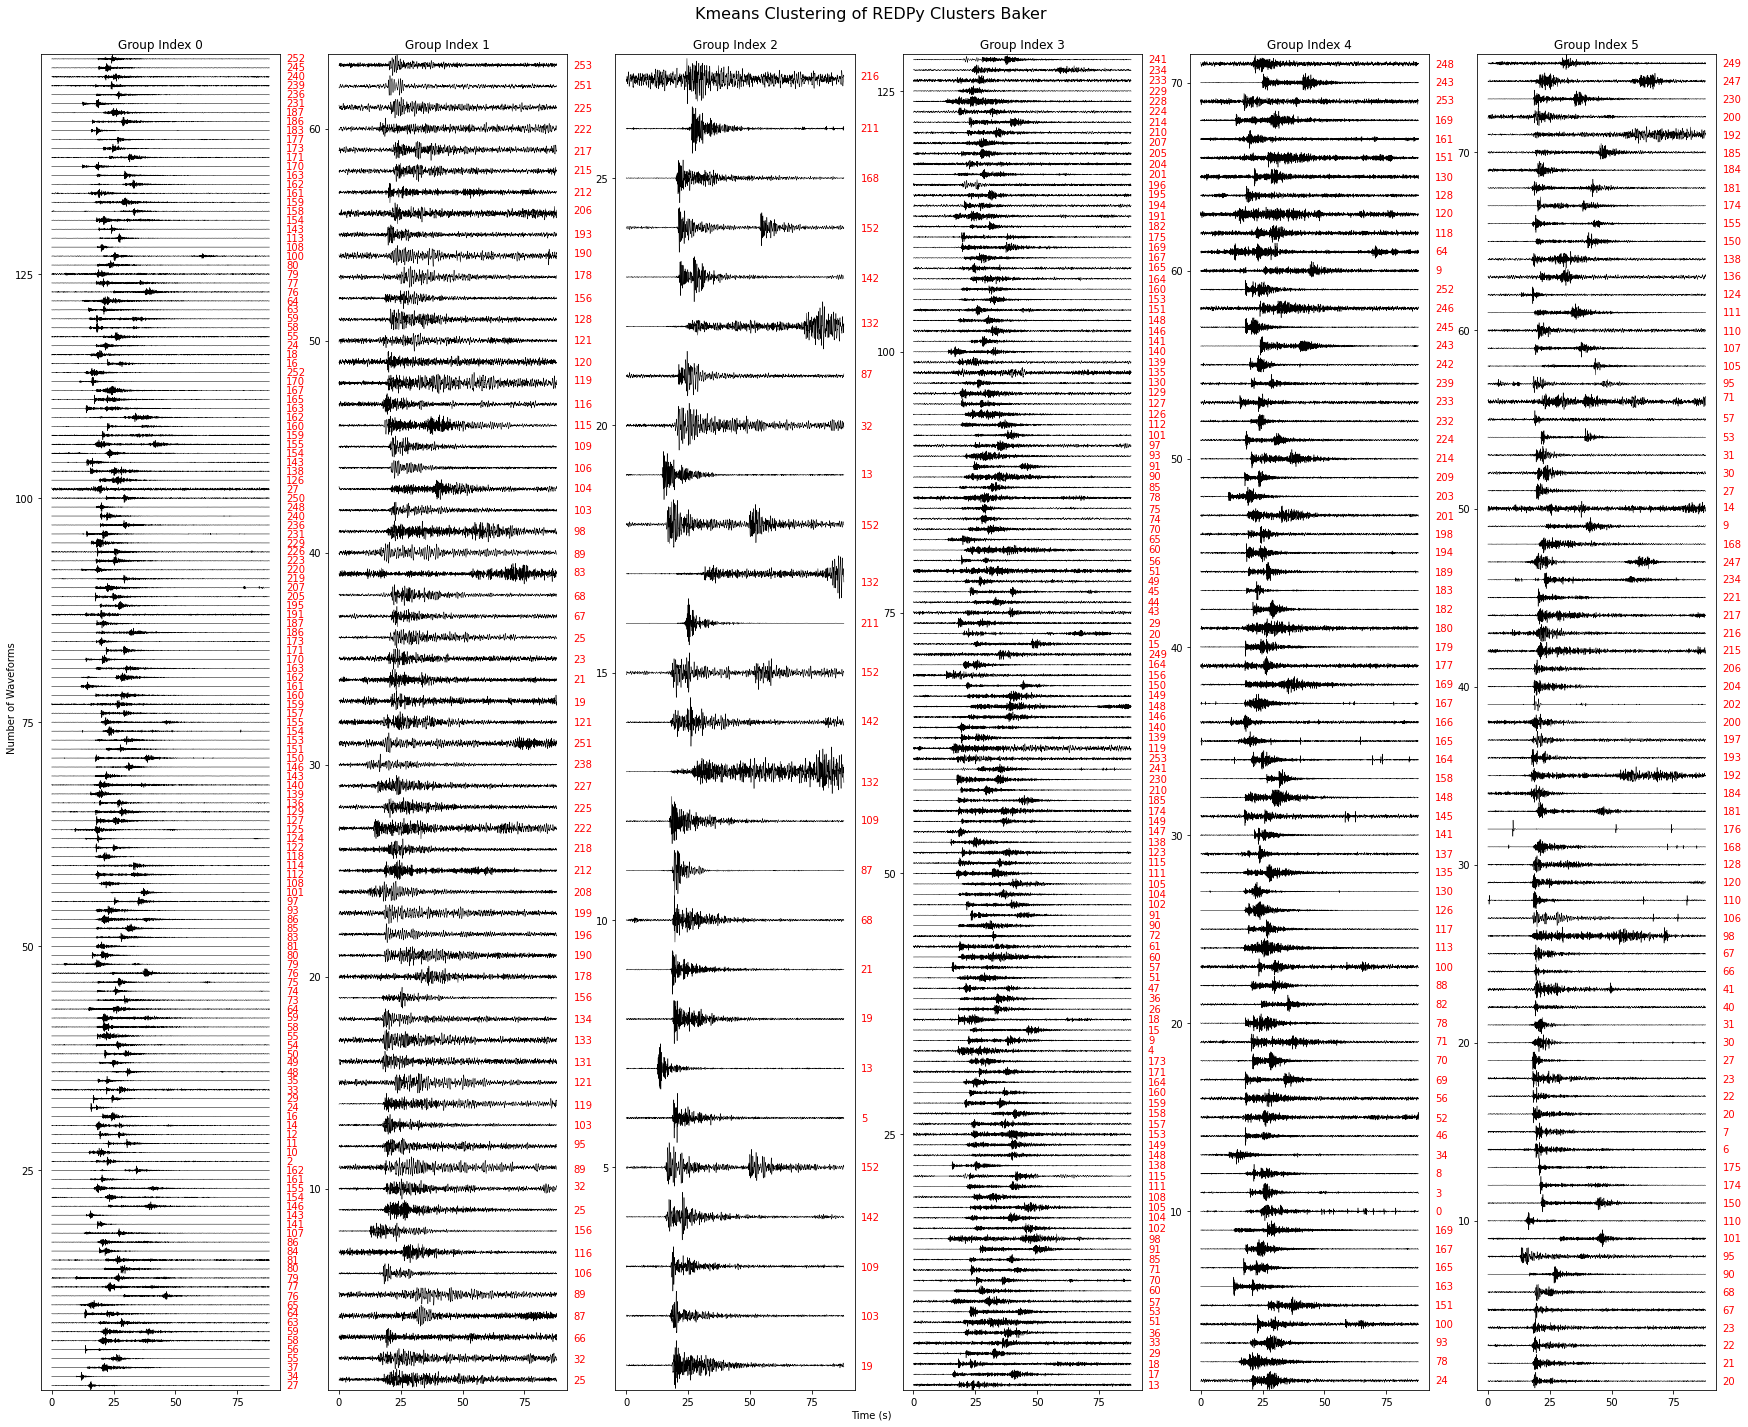

In [18]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import math
from obspy import Trace

k= max([int(i) for i in groups_df['kmeansID'].values.tolist()])+1

print('number of clusters =',k)

ax_list = np.arange(0,k,1) #list of groups, can do np.arange(0,n_clusters,1)

ncols = k #number of columns, can be set manually
nrows = math.ceil(k/ncols) #determines number of rows needed by rounding up to nearest whole number

fig, ax0 = plt.subplots(figsize=(ncols*4,nrows*20))
gs = GridSpec(nrows, ncols, figure=fig) #make GridSpec for formatting subplots, based on ncols and nrows
fig.suptitle(f'Kmeans Clustering of REDPy Clusters {volc_list_names[vv]}',fontsize=16)
# fig.set_tight_layout(True)
fig.tight_layout(rect=[0, 0, 1, 0.975])


for aa,ax_n in enumerate(ax_list):#for each subplot
#     print(f'----{ax_n}----')
    ax = fig.add_subplot(gs[math.floor(aa/ncols):math.floor(aa/ncols)+1,aa - math.floor(aa/ncols)*ncols:aa - math.floor(aa/ncols)*ncols +1]) #add subplot
    ax.set_title(f'Group Index {ax_n}') #label
    
    
    wave_list = [Trace(i) for i in groups_df[groups_df['kmeansID']==aa]['waveform'].values.tolist()] #list of waveforms for a Kmeans group
    name_list = [get_clid(i) for i in groups_df[groups_df['kmeansID']==aa]['template'].values.tolist()] #list of names for a Kmeans group

    print(len(wave_list),'waveforms', end=', ')
    
    yscale = 2 #how far to space waveforms from eachother
    wavecolor = 'black'
    for ww, wave in enumerate(wave_list):
        ax.plot(wave.data[:]/np.max(np.abs(wave.data))+yscale+(yscale*ww),color=wavecolor,linewidth=.5)
        
    for line, name in zip(ax.lines, name_list): #label each waveform with the cluster id
        y = line.get_ydata()[-1] #find the y value where the line ends
        ax.annotate(name, xy=(1,y), xytext=(6,0), color='red', 
                    xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                    size=10, va="center")
    
    x = np.arange(0,len(wave.data),1) #get np array of x points
    xscale = 40 #samling rate in hz
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/xscale)) #set ticks in seconds instead of samples, 40 is sampling rate
    ax.xaxis.set_major_formatter(ticks) #set ticks
#     ax.set_xlabel('Time (s)')
    
    y = np.arange(1,len(wave_list),1) #get np array of y points
    #yscale defined above
    ticks = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/yscale)) #set ticks in seconds instead of samples, 40 is sampling rate
    ax.yaxis.set_major_formatter(ticks) #set ticks
    ax.set_ylim(1,(len(wave_list)*yscale)+(.5*yscale))
#     ax.set_ylabel('Number of Waveforms')
    
fig.delaxes(ax0) #remove unused ax
fig.text(0.5, 0.0, 'Time (s)', ha='center')
fig.text(0.0, 0.5, 'Number of Waveforms', va='center', rotation='vertical')

print('showing plot...')

fig.savefig(f'/home/smocz/expand_redpy_new_files/newcl_method_{k}kmeans_{volc_list_names[vv]}.svg')

In [ ]:
#get 'confidence score' AKA the largest percent of templates within a REDPy cluster that are in the same kmeans cluster
#100% would mean that all templates (stations) within one REDPy cluster (e.g. cluster 010) are in the same kmeans cluster (e.g. group 1)
tie_count=[]
    
for cl in [get_clid(i) for i in all_temps]: #for this clusterid (REDPy)
    
#     print('----')    
#     print(f'cluster {cl}')
    
    count_list = []
    for k in np.unique(groups_df['kmeansID']): #look through each kmeans list
        cl_list = [get_clid(i) for i in groups_df[groups_df['kmeansID']==k]['template'].values.tolist()]
        count_list.append(cl_list.count(cl)) #find how many instances of this REDPy cluster id are within the kmeans group
        
    if count_list.count(max(count_list)) > 1: #if there is a tie (more than one instance of the maximum count)
        
        kgrp_list = []
        for idx, num in enumerate(count_list): #find the indexes (kmeans grp id) for each maximum count
            if num==max(count_list):
                kgrp_list.append(idx)
        percent_in_cluster = round(count_list[kgrp_list[0]]/sum(count_list), 2) #calculate the percent in each of these kmeans grps
        
        print(f'there is a tie between kmeans groups {kgrp_list} at {round(percent_in_cluster*100)}%')
        
        tie_count.append('tie')
    else:
        most_common_cluster = count_list.index(max(count_list)) #find the index (kmeans grp id) of the maximum count
        percent_in_cluster = round(count_list[most_common_cluster]/sum(count_list), 2) #caculate the percent in this kmeans grp
        
        print(f'the most common kmeans group is {most_common_cluster} at {round(percent_in_cluster*100)}%')
        tie_count.append('winner')
#     break

print(f"{round((tie_count.count('tie')/len(tie_count))*100)}% of clusters have ties")

### COP-Kmeans Analysis ###

In [52]:
#read csv

groups_df = pd.read_csv(cop_kmeans_name)
groups_df.head()

,template,kmeansID
0,CN_VDB_rpba_13,3
1,CN_VDB_rpba_17,0
2,CN_VDB_rpba_18,0
3,CN_VDB_rpba_19,1
4,CN_VDB_rpba_20,1


In [53]:
#add waveform to dataframe
groups_df['waveform']= [i for i in all_waves]

In [54]:
groups_df.head()

,template,kmeansID,waveform
0,CN_VDB_rpba_13,3,"[-0.0134396711252262, -0.014672842092771553, -..."
1,CN_VDB_rpba_17,0,"[0.0008055376400464358, -0.0045865051656801235..."
2,CN_VDB_rpba_18,0,"[-0.011902026118720373, 0.025556739409762674, ..."
3,CN_VDB_rpba_19,1,"[-0.01284348664224888, -0.0024739919789767257,..."
4,CN_VDB_rpba_20,1,"[0.004830974781062498, 0.005037140076776008, -..."


number of clusters = 6
111 waveforms, 84 waveforms, 85 waveforms, 84 waveforms, 100 waveforms, 49 waveforms, showing plot...


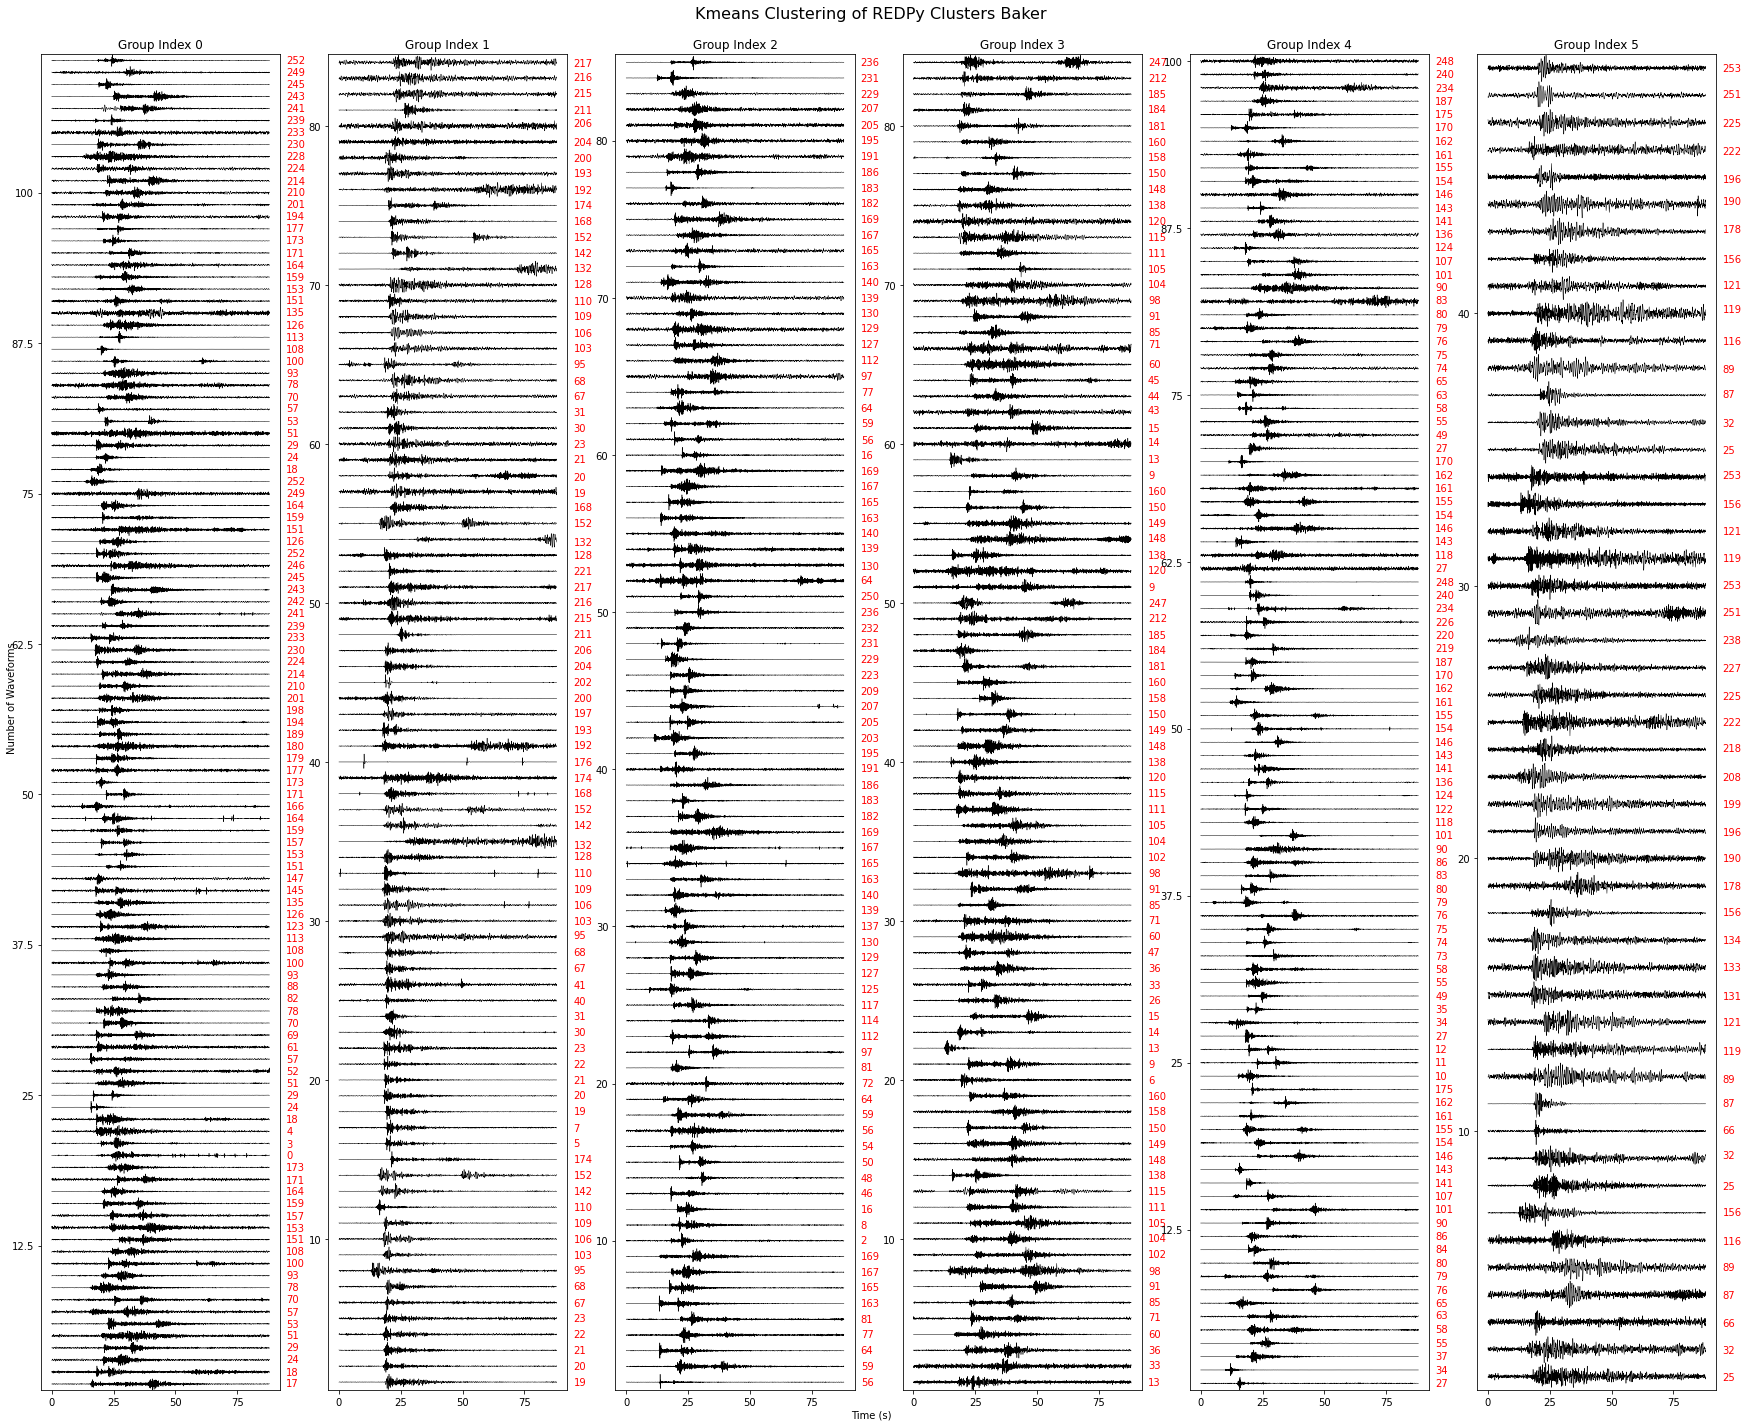

In [60]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import math
from obspy import Trace

k= max([int(i) for i in groups_df['kmeansID'].values.tolist()])+1
plot_station = groups_df['template'][0].split('_')[1] #which station to show waveforms from
#default station is the first one in the csv. Helps to keep plot small and show similarities across clusters

print('number of clusters =',k)

ax_list = np.arange(0,k,1) #list of groups, can do np.arange(0,n_clusters,1)

ncols = k #number of columns, can be set manually
nrows = math.ceil(k/ncols) #determines number of rows needed by rounding up to nearest whole number

fig, ax0 = plt.subplots(figsize=(ncols*4,nrows*20))
gs = GridSpec(nrows, ncols, figure=fig) #make GridSpec for formatting subplots, based on ncols and nrows
fig.suptitle(f'Kmeans Clustering of REDPy Clusters {volc_list_names[vv]}',fontsize=16)
# fig.set_tight_layout(True)
fig.tight_layout(rect=[0, 0, 1, 0.975])


for aa,ax_n in enumerate(ax_list):#for each subplot
#     print(f'----{ax_n}----')
    ax = fig.add_subplot(gs[math.floor(aa/ncols):math.floor(aa/ncols)+1,aa - math.floor(aa/ncols)*ncols:aa - math.floor(aa/ncols)*ncols +1]) #add subplot
    ax.set_title(f'Group Index {ax_n}') #label
    
    
    wave_list = [Trace(i) for i in groups_df[groups_df['kmeansID']==aa]['waveform'].values.tolist()] #list of waveforms for a Kmeans group
    name_list = [get_clid(i) for i in groups_df[groups_df['kmeansID']==aa]['template'].values.tolist()] #list of names for a Kmeans group

    print(len(wave_list),'waveforms', end=', ')
    
    yscale = 2 #how far to space waveforms from eachother
    wavecolor = 'black'
    for ww, wave in enumerate(wave_list):
        ax.plot(wave.data[:]/np.max(np.abs(wave.data))+yscale+(yscale*ww),color=wavecolor,linewidth=.5)
        
    for line, name in zip(ax.lines, name_list): #label each waveform with the cluster id
        y = line.get_ydata()[-1] #find the y value where the line ends
        ax.annotate(name, xy=(1,y), xytext=(6,0), color='red', 
                    xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                    size=10, va="center")
    
    x = np.arange(0,len(wave.data),1) #get np array of x points
    xscale = 40 #samling rate in hz
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/xscale)) #set ticks in seconds instead of samples, 40 is sampling rate
    ax.xaxis.set_major_formatter(ticks) #set ticks
#     ax.set_xlabel('Time (s)')
    
    y = np.arange(1,len(wave_list),1) #get np array of y points
    #yscale defined above
    ticks = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/yscale)) #set ticks in seconds instead of samples, 40 is sampling rate
    ax.yaxis.set_major_formatter(ticks) #set ticks
    ax.set_ylim(1,(len(wave_list)*yscale)+(.5*yscale))
#     ax.set_ylabel('Number of Waveforms')
    
fig.delaxes(ax0) #remove unused ax
fig.text(0.5, 0.0, 'Time (s)', ha='center')
fig.text(0.0, 0.5, 'Number of Waveforms', va='center', rotation='vertical')

print('showing plot...')

fig.savefig(f'/home/smocz/expand_redpy_new_files/newcl_method_{k}COPkmeans_{volc_list_names[vv]}.svg')